In [ ]:
!pip install rasterio

In [ ]:
import os
import glob
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix ,jaccard_score
import seaborn as sns
import numpy as np
import rasterio
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.image import resize
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.transform import resize as sk_resize


In [ ]:
zip_path = "data.zip"
extract_path = "data_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
image_dir = os.path.join(extract_path, "data/images")
label_dir = os.path.join(extract_path, "data/labels")
print(os.listdir(extract_path))
print(os.listdir(image_dir))
print(os.listdir(label_dir))

['data']
['25.tif', '60.tif', '88.tif', '222.tif', '298.tif', '69.tif', '237.tif', '270.tif', '256.tif', '61.tif', '111.tif', '226.tif', '180.tif', '54.tif', '9.tif', '121.tif', '89.tif', '177.tif', '133.tif', '138.tif', '132.tif', '187.tif', '95.tif', '62.tif', '207.tif', '51.tif', '56.tif', '118.tif', '230.tif', '299.tif', '20.tif', '26.tif', '17.tif', '63.tif', '102.tif', '248.tif', '40.tif', '198.tif', '76.tif', '87.tif', '246.tif', '179.tif', '287.tif', '33.tif', '106.tif', '3.tif', '295.tif', '170.tif', '8.tif', '152.tif', '112.tif', '80.tif', '277.tif', '215.tif', '150.tif', '34.tif', '278.tif', '245.tif', '84.tif', '301.tif', '253.tif', '21.tif', '107.tif', '216.tif', '32.tif', '217.tif', '267.tif', '98.tif', '189.tif', '6.tif', '39.tif', '163.tif', '28.tif', '296.tif', '101.tif', '126.tif', '18.tif', '143.tif', '167.tif', '140.tif', '294.tif', '293.tif', '281.tif', '1.tif', '23.tif', '197.tif', '13.tif', '82.tif', '156.tif', '242.tif', '224.tif', '274.tif', '195.tif', '113.tif

## 🌍 قنوات Sentinel-2 (12 Bands)

| رقم القناة | الاسم                             | الطول الموجي (نانومتر) | الدقة (متر) | الاستخدام                                                  |
| ---------- | --------------------------------- | ---------------------- | ----------- | ---------------------------------------------------------- |
| **B1**     | Coastal aerosol (ساحلي/أزرق غامق) | 443                    | 60m         | قياس الجسيمات في الغلاف الجوي والبحر، تمييز السحب الرقيقة. |
| **B2**     | Blue (أزرق)                       | 490                    | 10m         | تحليل المياه الضحلة، التمييز بين الماء/الأرض.              |
| **B3**     | Green (أخضر)                      | 560                    | 10m         | يعكس الغطاء النباتي، قريب من ما تراه العين.                |
| **B4**     | Red (أحمر)                        | 665                    | 10m         | يوضح التربة، يساعد في التمييز بين الماء/النباتات.          |
| **B5**     | Vegetation Red Edge 1             | 705                    | 20m         | حساس لصحة النباتات (الانتقال من الأحمر إلى NIR).           |
| **B6**     | Vegetation Red Edge 2             | 740                    | 20m         | تقييم الغطاء النباتي والكثافة.                             |
| **B7**     | Vegetation Red Edge 3             | 783                    | 20m         | الغطاء النباتي (زي الـ B6 لكن بتردد مختلف).                |
| **B8**     | NIR (Near Infrared)               | 842                    | 10m         | الماء = غامق جدًا / النبات = فاتح جدًا. أهم Band للزراعة.  |
| **B8A**    | Narrow NIR                        | 865                    | 20m         | قياس دقيق لصحة النباتات، تكملة لـ NDVI.                    |
| **B9**     | Water vapor                       | 945                    | 60m         | قياس بخار الماء في الغلاف الجوي.                           |
| **B11**    | SWIR 1 (Shortwave Infrared)       | 1610                   | 20m         | التربة، الرطوبة، التمييز بين سحب/ثلج/جليد.                 |
| **B12**    | SWIR 2 (Shortwave Infrared)       | 2190                   | 20m         | خرائط الحرائق، الجفاف، الصخور والمعادن.                    |

---

## 🎯 الاستخدام العملي

* **الماء**: B2, B3, B4, B8 (لأنها تظهر المياه بوضوح).
* **النباتات**: B5, B6, B7, B8, B8A (تظهر صحة الغطاء النباتي).
* **التربة والصخور**: B11, B12 (للتفريق بين أنواع التربة والرطوبة).
* **الغلاف الجوي**: B1, B9 (للتصحيح الجوي).




Image shape: (12, 128, 128)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


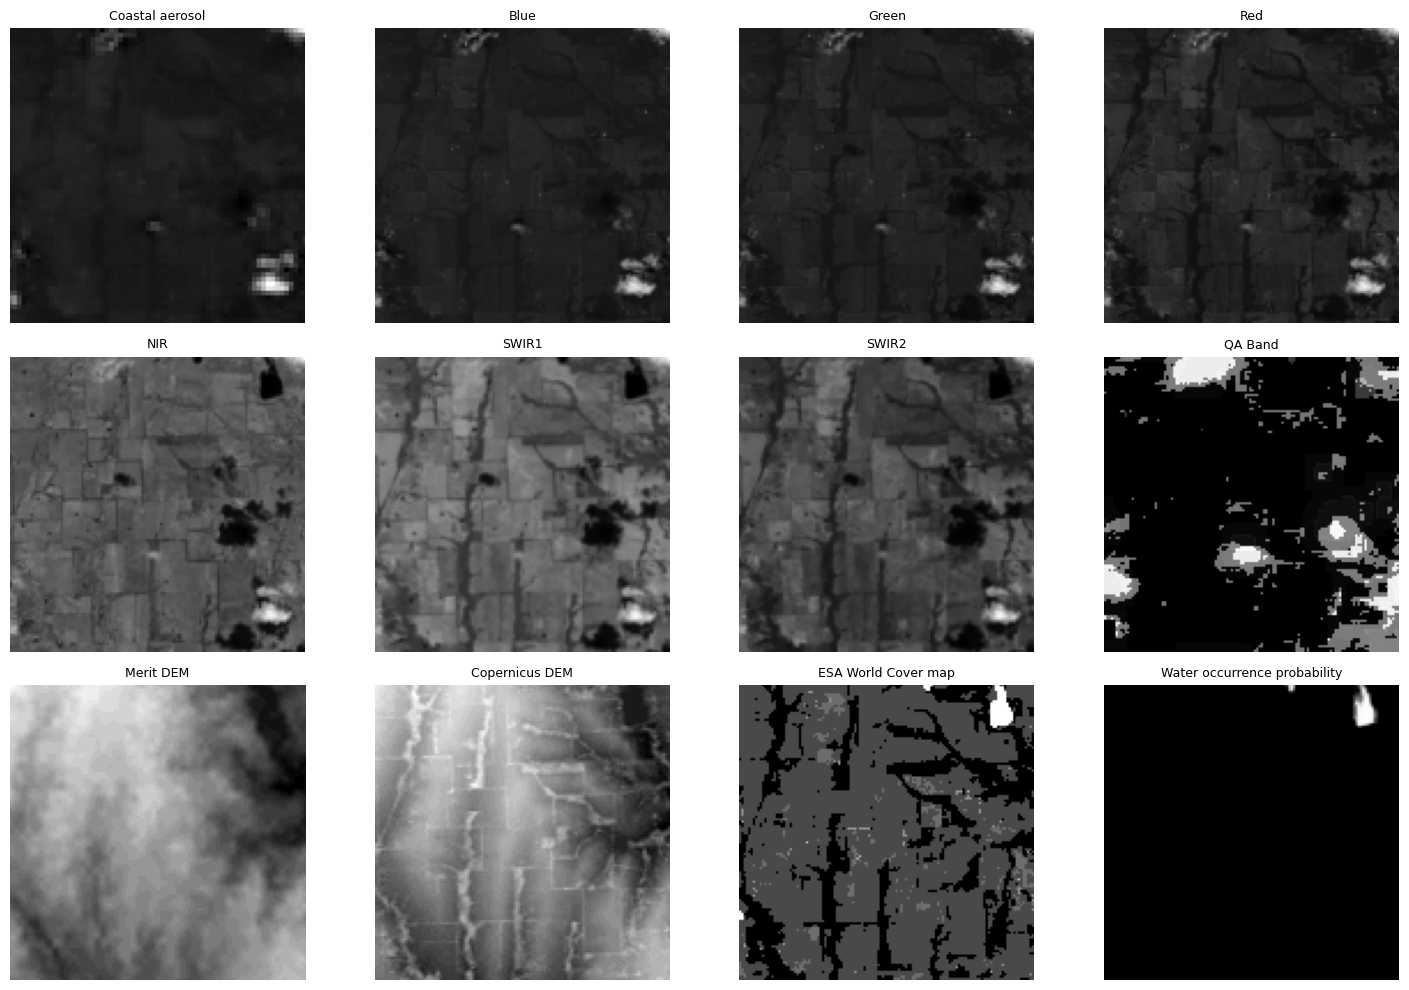

In [ ]:
channel_names = [
    "Coastal aerosol",
    "Blue",
    "Green",
    "Red",
    "NIR",
    "SWIR1",
    "SWIR2",
    "QA Band",
    "Merit DEM",
    "Copernicus DEM",
    "ESA World Cover map",
    "Water occurrence probability"
]

img_files = os.listdir(image_dir)
img_path = os.path.join(image_dir, img_files[0])

with rasterio.open(img_path) as src:
    img = src.read()

print("Image shape:", img.shape)

num_channels = img.shape[0]
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_channels):
    axes[i].imshow(img[i], cmap="gray")
    axes[i].set_title(channel_names[i], fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

📌 معنى كل قناة:

Band 2 (Blue)

حساسة جدًا للمياه الضحلة.

المياه بتمتص الضوء في الأزرق بشكل مميز مقارنة باليابسة.

Band 3 (Green)

بيساعد في التمييز بين المياه والنباتات.

الماء غالبًا بيبان غامق، لكن الغطاء النباتي بيبان أفتح.

Band 7 (NIR  Near Infrared)

أهم قناة للكشف عن المياه.

المياه بتمتص الـ NIR بقوة → بتظهر غامقة جدًا.

اليابسة والنباتات بيعكسوا الـ NIR → بيظهروا فاتحين.

In [ ]:
best_channels = ["Blue", "Green", "Red", "NIR", "SWIR1"]
selected_channels = [channel_names.index(band) for band in best_channels]

def load_dataset(image_dir, label_dir, selected_channels=selected_channels, target_size=(128,128)):

    images, masks = [], []

    image_files = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
    label_files = sorted(glob.glob(os.path.join(label_dir, "*.png")))

    image_names = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
    label_names = [os.path.splitext(os.path.basename(f))[0] for f in label_files]
    common_names = sorted(set(image_names).intersection(set(label_names)))

    print(f"Found {len(image_files)} images, {len(label_files)} masks, {len(common_names)} common pairs.")

    for name in common_names:
        img_path = os.path.join(image_dir, name + ".tif")
        lbl_path = os.path.join(label_dir, name + ".png")

        if not os.path.exists(img_path) or not os.path.exists(lbl_path):
            continue

        with rasterio.open(img_path) as src:
            img = src.read()
            img = np.transpose(img, (1,2,0))
            img = img[:,:,selected_channels]

        img_resized = sk_resize(img, target_size, preserve_range=True)
        img_resized = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-6)

        mask = rasterio.open(lbl_path).read(1)
        mask = (mask > 0).astype(np.float32)

        mask_resized = sk_resize(mask, target_size, preserve_range=True, anti_aliasing=True)
        mask_resized = (mask_resized > 0.5).astype(np.float32)

        images.append(img_resized)
        masks.append(mask_resized)

    X = np.array(images, dtype=np.float32)
    Y = np.array(masks, dtype=np.float32)
    Y = np.expand_dims(Y, axis=-1)

    print("Dataset shape:", X.shape, Y.shape)
    return X, Y


X, Y = load_dataset(image_dir, label_dir)

Found 306 images, 456 masks, 306 common pairs.
Dataset shape: (306, 128, 128, 5) (306, 128, 128, 1)


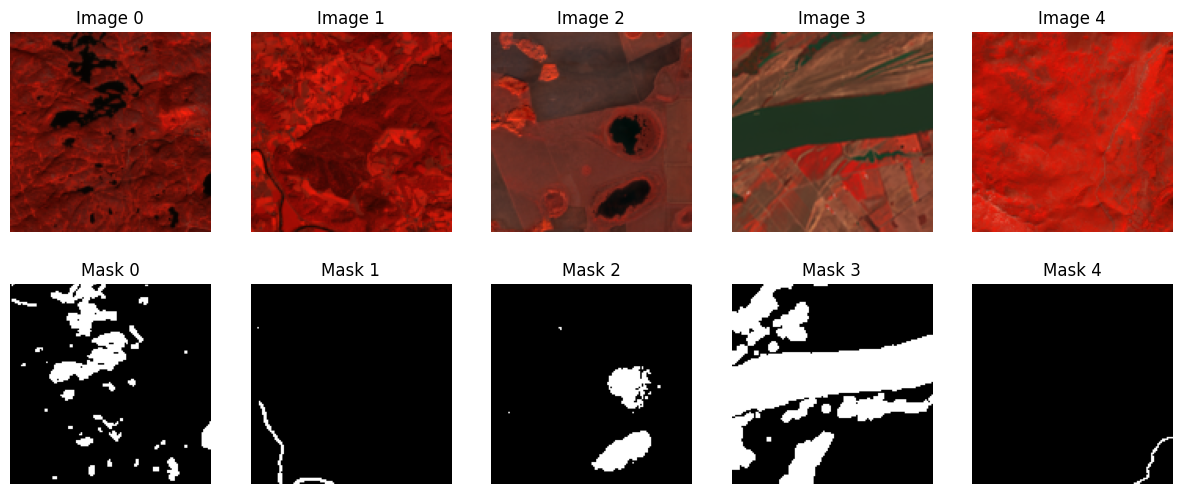

In [ ]:
def preview_dataset(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # ترتيبهم حسب اختيارنا من selected_channels: Blue=0, Green=1, Red=2, NIR=3, SWIR1=4
        img = images[i][:,:, [3,1,0]]

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")
    plt.show()


preview_dataset(X, Y, n=5)


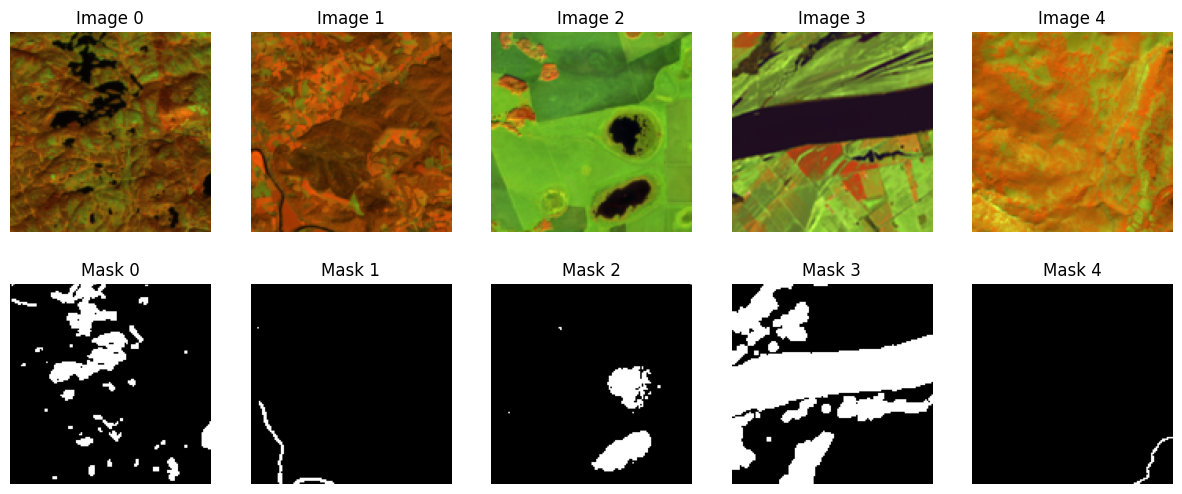

In [ ]:
def preview_dataset2(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # ترتيبهم حسب اختيارنا من selected_channels: Blue=0, Green=1, Red=2, NIR=3, SWIR1=4
        img = images[i][:,:, [3,4,0]]

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")
    plt.show()

#
preview_dataset2(X, Y, n=5)

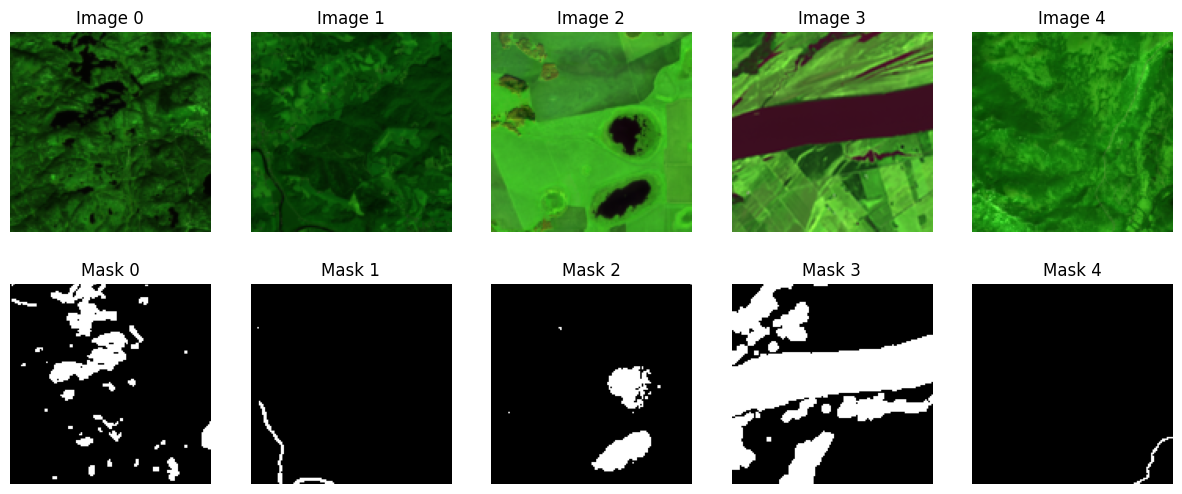

In [ ]:
def preview_dataset3(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # ترتيبهم حسب اختيارنا من selected_channels: Blue=0, Green=1, Red=2, NIR=3, SWIR1=4
        img = images[i][:,:, [2,4,0]]

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")
    plt.show()


preview_dataset3(X, Y, n=5)

In [ ]:
def preview_dataset4(images, masks, n=3, band_names=["Blue","Green","Red","NIR","SWIR1"]):
    for i in range(n):
        plt.figure(figsize=(15, 8))

        for j in range(images.shape[-1]):
            plt.subplot(2, images.shape[-1]//2 + 2, j+1)
            plt.imshow(images[i][:,:,j], cmap="gray")
            plt.title(f"{band_names[j]}")
            plt.axis("off")

        rgb_img = images[i][:,:, [2,1,0]]
        plt.subplot(2, images.shape[-1]//2 + 2, images.shape[-1]+1)
        plt.imshow(rgb_img)
        plt.title("RGB Composite")
        plt.axis("off")

        plt.subplot(2, images.shape[-1]//2 + 2, images.shape[-1]+2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.suptitle(f"Sample {i}", fontsize=14)
        plt.tight_layout()
        plt.show()



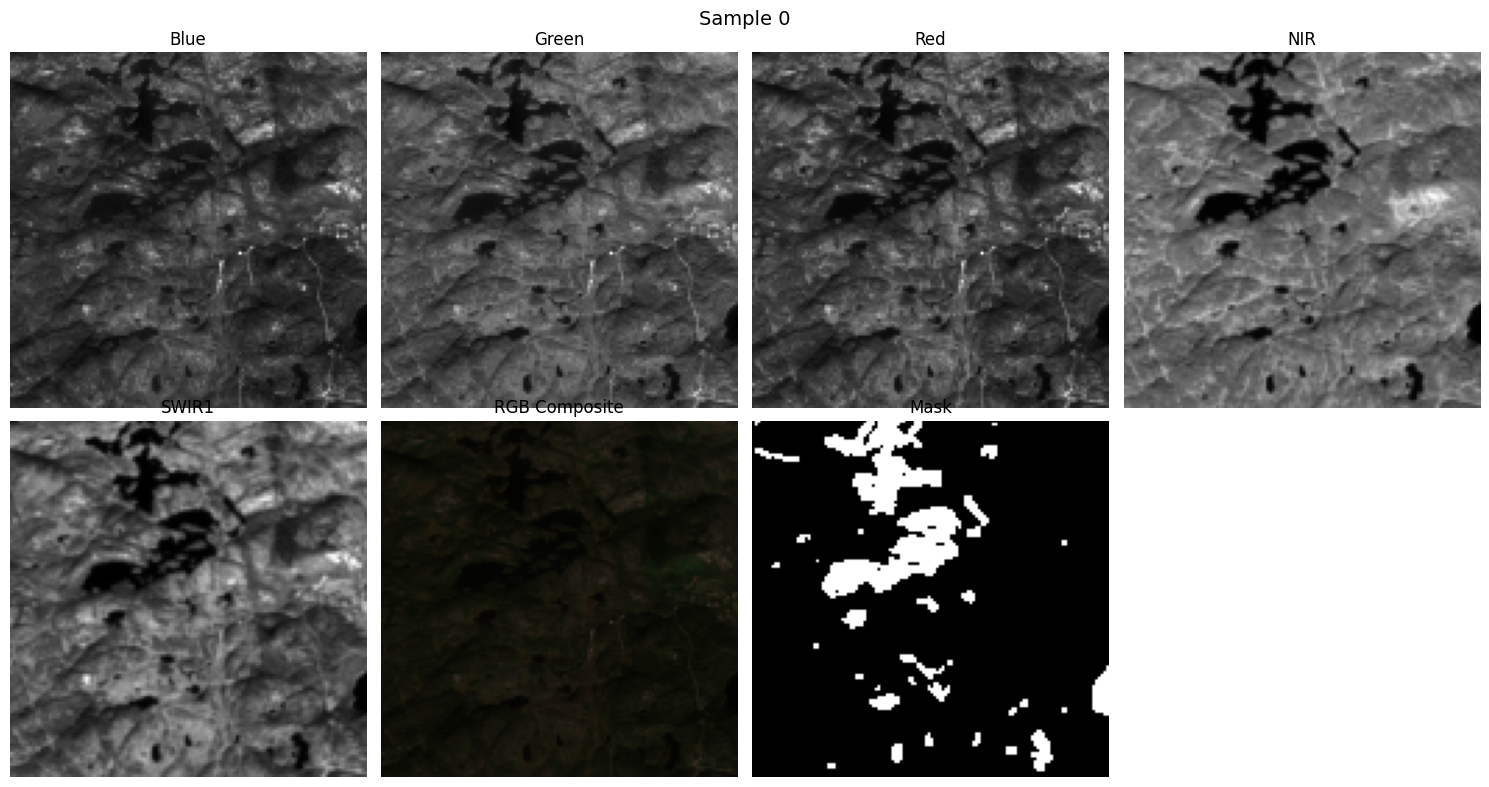

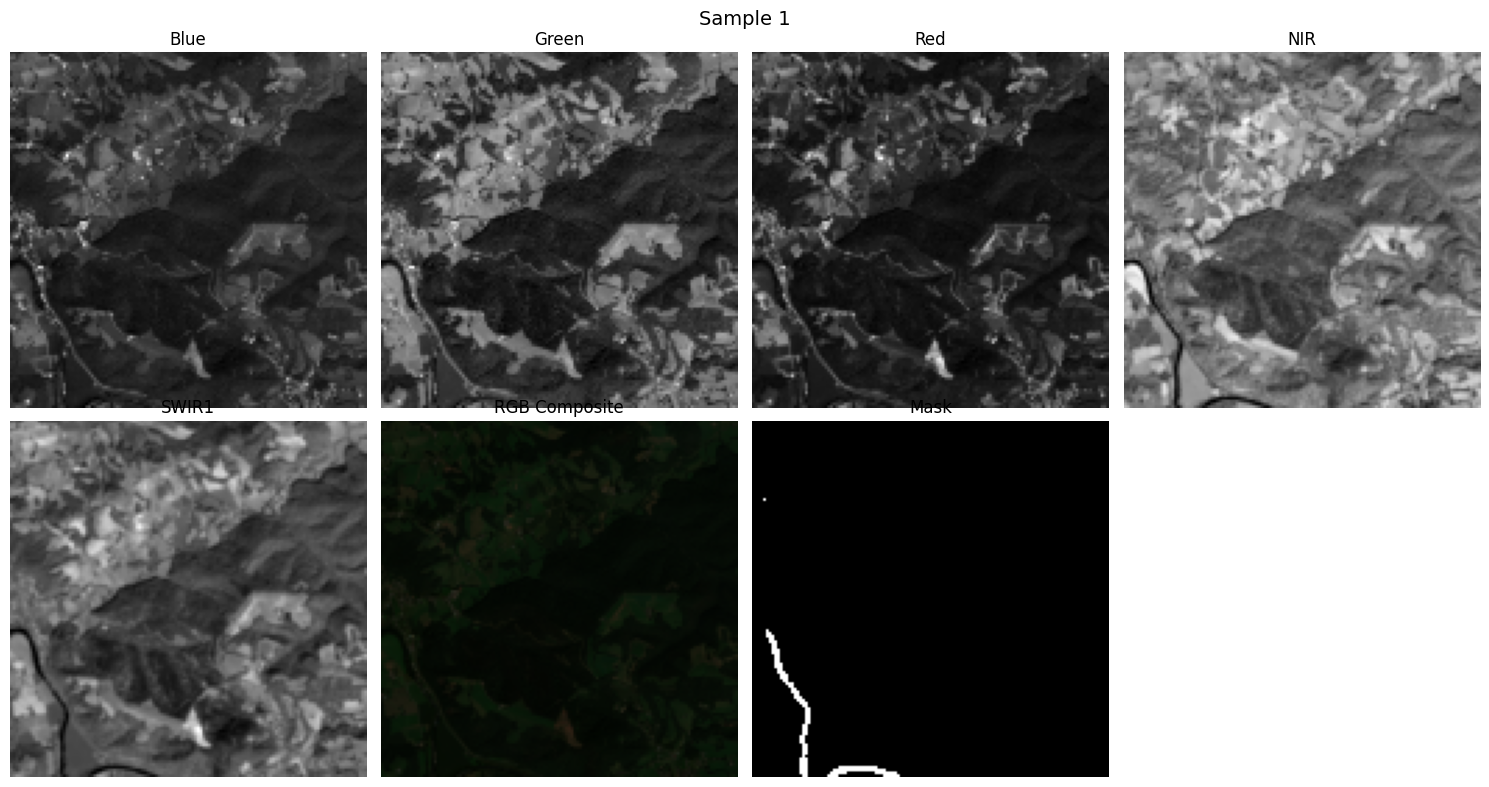

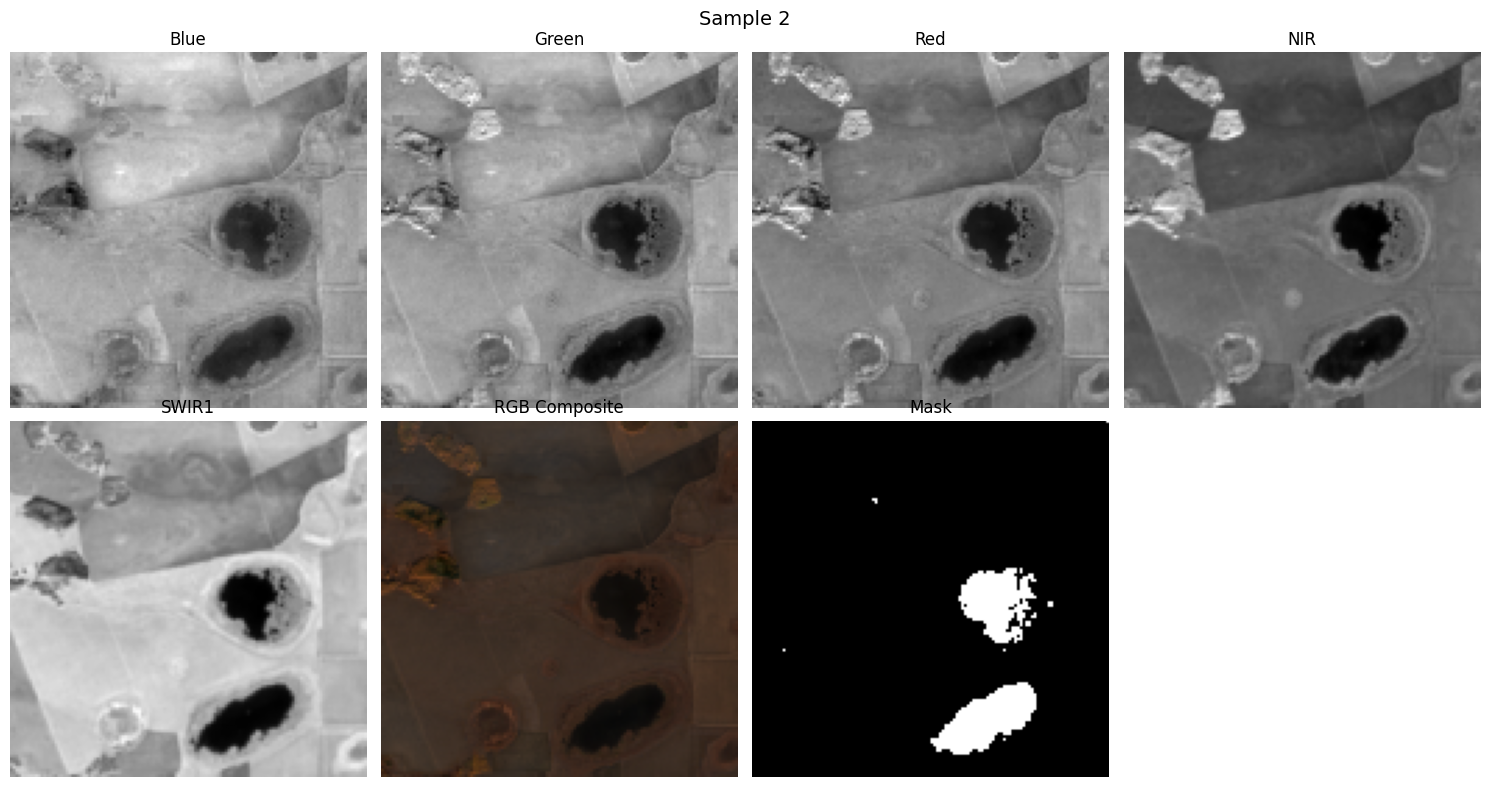

In [ ]:
preview_dataset4(X, Y, n=3)

In [ ]:
images = X.astype(np.float32) / 255.0
masks = Y.astype(np.float32)
masks = np.expand_dims(masks, axis=-1)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (306, 128, 128, 5)
Masks shape: (306, 128, 128, 1, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [ ]:
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    X = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    X = layers.Conv2D(16, 3, activation="relu", padding="same")(X)
    X = layers.MaxPooling2D()(X)

    X = layers.Conv2D(32,3, activation="relu", padding="same")(X)
    X = layers.Conv2D(32,3, activation="relu", padding="same")(X)
    X = layers.MaxPooling2D()(X)

    X = layers.Conv2D(64,3, activation="relu", padding="same")(X)
    X = layers.Conv2D(64,3, activation="relu", padding="same")(X)

    X = layers.UpSampling2D()(X)
    X = layers.Concatenate()([X, X])
    X = layers.Conv2D(32, 3, activation="relu", padding="same")(X)
    X = layers.Conv2D(32, 3, activation="relu", padding="same")(X)

    X = layers.UpSampling2D()(X)
    X = layers.Concatenate()([X, X])
    X = layers.Conv2D(16, 3, activation="relu", padding="same")(X)
    X = layers.Conv2D(16,3, activation="relu", padding="same")(X)

    outputs = layers.Conv2D(1,1, activation="sigmoid")(X)

    model = models.Model(inputs, outputs)
    return model

model = unet_model(input_shape=X_train.shape[1:])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        736 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 128)              │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     36,896 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 64)               │            │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      9,232 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 130,081 (508.13 KB)

 Trainable params: 130,081 (508.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
checkpoint_path = "best_model.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [49]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks= checkpoint
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7464 - loss: 0.6285
Epoch 1: val_accuracy improved from -inf to 0.77563, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7459 - loss: 0.6278 - val_accuracy: 0.7756 - val_loss: 0.5831
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7120 - loss: 0.6115
Epoch 2: val_accuracy did not improve from 0.77563
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7126 - loss: 0.6107 - val_accuracy: 0.7756 - val_loss: 0.5176
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7239 - loss: 0.5864
Epoch 3: val_accuracy did not improve from 0.77563
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7241 - loss: 0.5866 - val_accuracy: 0.7756 - val_loss: 0.5361
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7292 - loss: 0.5910
Epoch 4: val_accuracy did not improve from 0.77563
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7292 - loss: 0.5910 - val_a

In [50]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9170 - loss: 0.2349
Test Loss: 0.2363, Test Accuracy: 0.9163


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    787894
           1       0.90      0.71      0.79    227914

    accuracy                           0.92   1015808
   macro avg       0.91      0.84      0.87   1015808
weighted avg       0.92      0.92      0.91   1015808



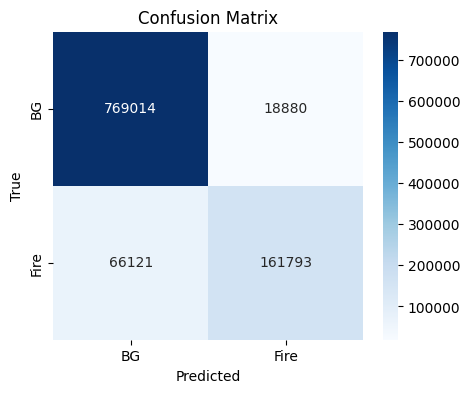

IoU: 0.6556


In [59]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_true_binary = y_test.astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_true_binary, y_pred_binary))

cm = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["BG","Fire"], yticklabels=["BG","Fire"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

tn, fp, fn, tp = cm.ravel()
iou = tp / (tp + fp + fn)
print(f"IoU: {iou:.4f}")

In [52]:
# from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121, InceptionV3, MobileNetV2

# NUM_CLASSES = len(np.unique(masks))
# models_dict = {
#     "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)),
#     "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3)),
#     "DenseNet121": DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3)),
#     "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)),
#     "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
# }

# history_dict = {}
# accuracy_scores = {}

In [53]:
# def build_model(base_model, num_classes):
#     base_model.trainable = False
#     inputs = tf.keras.Input(shape=(224,224,3))
#     x = base_model(inputs, training=False)
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(128, activation="relu")(x)
#     outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
#     model = tf.keras.Model(inputs, outputs)
#     return model

In [54]:
# for name, base_model in models_dict.items():
#     print(f"\n===== Training {name} =====")
#     model2 = build_model(base_model, NUM_CLASSES)

#     model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#     checkpoint = ModelCheckpoint(f"{name}_best.keras", save_best_only=True, monitor="val_accuracy", mode="max")

#     history2 = model2.fit(
#         X_train, y_train,
#         validation_data=(X_test, y_test),
#         epochs=50,
#         callbacks=[checkpoint],
#         verbose=1
#     )

#     # Evaluate
#     test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=0)
#     print(f"{name} Test Accuracy: {test_acc:.4f}")

#     history_dict[name] = history2
#     accuracy_scores[name] = (model2, test_acc)

#     # Plot history
#     plt.figure(figsize=(12,5))
#     plt.subplot(1,2,1)
#     plt.plot(history.history2['accuracy'], label="train acc")
#     plt.plot(history.history2['val_accuracy'], label="val acc")
#     plt.title(f"{name} Accuracy")
#     plt.legend()

#     plt.subplot(1,2,2)
#     plt.plot(history.history2['loss'], label="train loss")
#     plt.plot(history.history2['val_loss'], label="val loss")
#     plt.title(f"{name} Loss")
#     plt.legend()
#     plt.show()

In [55]:
# best_model_name = max(accuracy_scores, key=lambda k: accuracy_scores[k][1])
# best_model, best_acc = accuracy_scores[best_model_name]

# print(f"\nBest Model: {best_model_name} with accuracy {best_acc:.4f}")

In [56]:
# y_pred = np.argmax(best_model.predict(X_test), axis=1)

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6,6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.title(f"Confusion Matrix - {best_model_name}")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

In [57]:
# save_path = f"{best_model_name}_final.keras"
# best_model.save(save_path)
# print(f"Saved best model to {save_path}")